In [1]:
import numpy as np

X_test = np.load('../Data/processed data/X.npy')
y_test = np.load('../Data/processed data/y.npy')


In [2]:
from tensorflow import keras

model = keras.models.load_model('../Models/smart_waste_sorting_model.keras', compile=False)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [3]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")



79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.2721 - loss: 1.8429
Test Accuracy: 0.1959
Test Loss: 2.1206


79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step
              precision    recall  f1-score   support

           0       0.26      0.20      0.23       403
           1       0.19      0.59      0.29       501
           2       0.10      0.04      0.06       410
           3       0.21      0.08      0.12       594
           4       0.30      0.09      0.14       482
           5       0.07      0.07      0.07       137

    accuracy                           0.20      2527
   macro avg       0.19      0.18      0.15      2527
weighted avg       0.21      0.20      0.16      2527



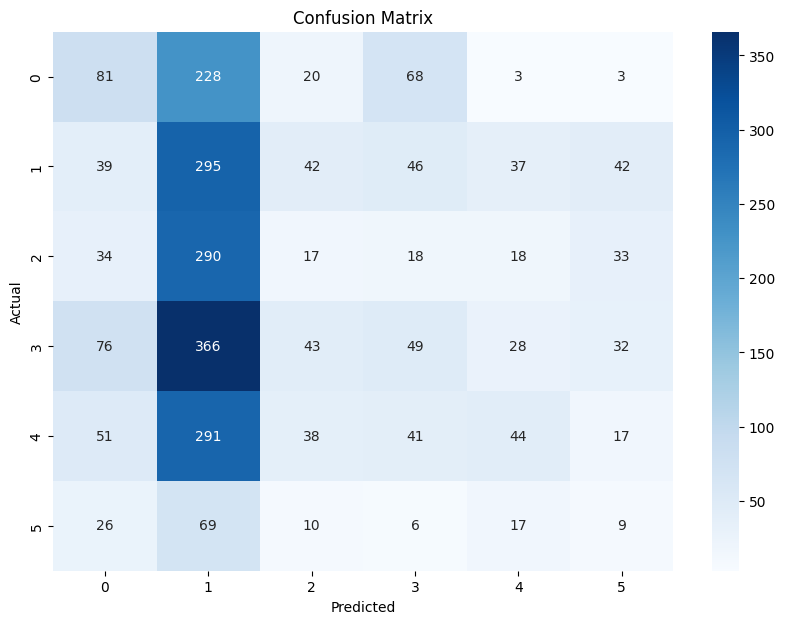

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


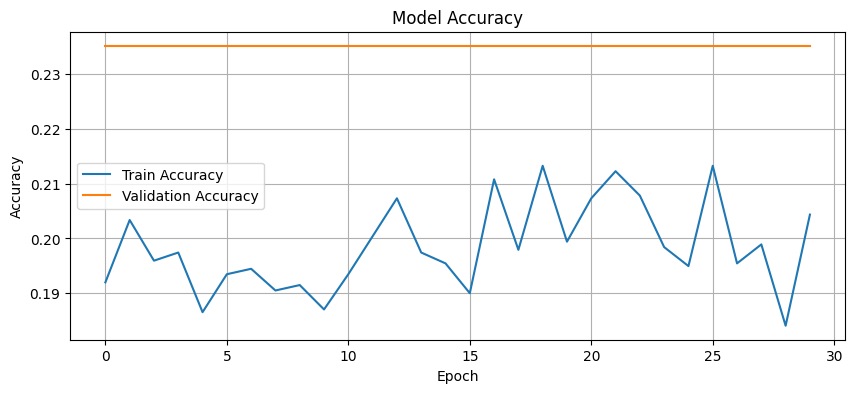

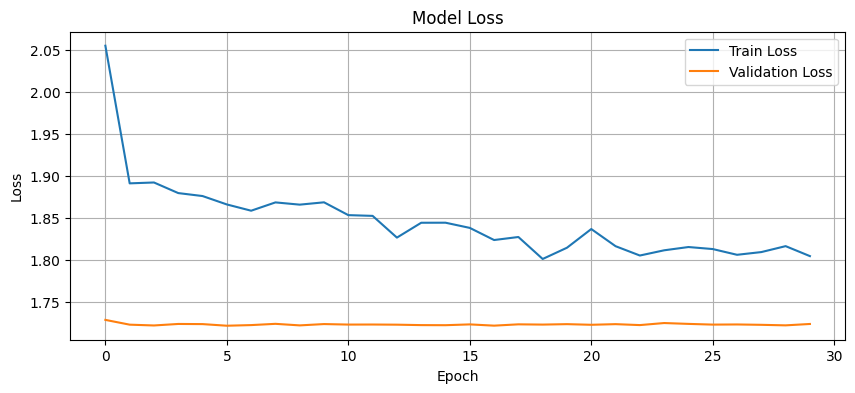

In [5]:
import pickle
import matplotlib.pyplot as plt

# Load training history
with open('../Models/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]
final_train_loss = history['loss'][-1]
final_val_loss = history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.2044
Final Validation Accuracy: 0.2352
Final Training Loss: 1.8049
Final Validation Loss: 1.7243


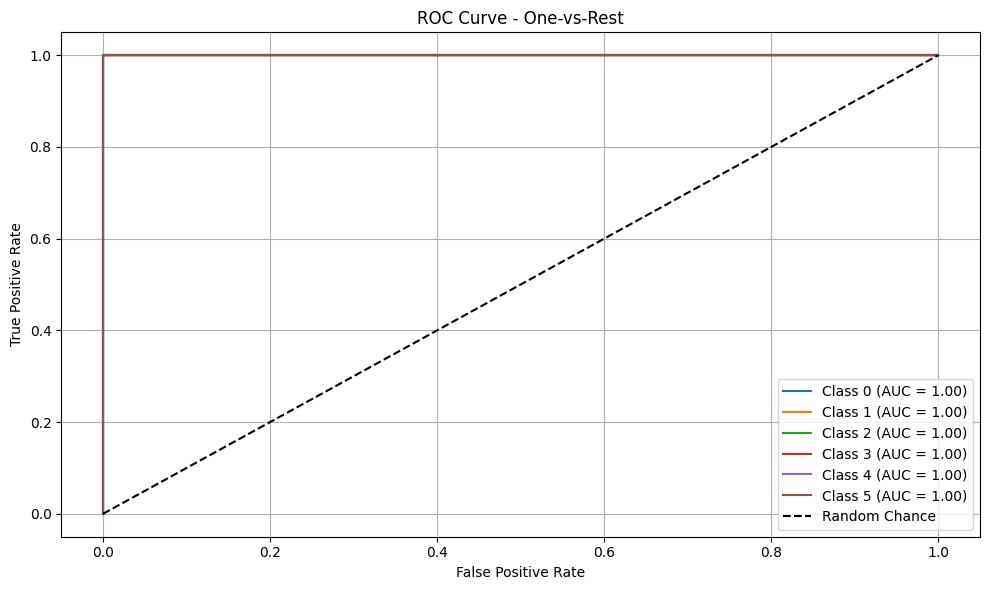

In [7]:
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# One-hot encode labels
y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

# Flatten image data
X_flat = X_test.reshape((X_test.shape[0], -1))

# Standardize features
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Train One-vs-Rest classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=3000))
classifier.fit(X_flat_scaled, y_bin)
y_score = classifier.decision_function(X_flat_scaled)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.title("ROC Curve - One-vs-Rest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()




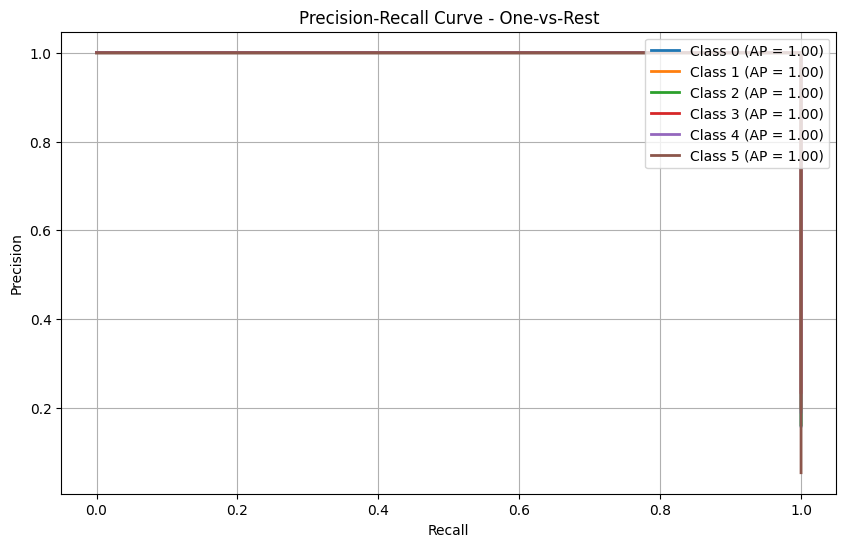

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f"Class {i} (AP = {avg_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - One-vs-Rest")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [9]:
# Convert continuous scores to predicted labels (one-hot to class index)
y_pred_labels = np.argmax(y_score, axis=1)
y_true_labels = np.argmax(y_bin, axis=1)  # since y_test was binarized too

from sklearn.metrics import classification_report
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

print("Detailed Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


Detailed Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00       403
       glass       1.00      1.00      1.00       501
       metal       1.00      1.00      1.00       410
       paper       1.00      1.00      1.00       594
     plastic       1.00      1.00      1.00       482
       trash       1.00      1.00      1.00       137

    accuracy                           1.00      2527
   macro avg       1.00      1.00      1.00      2527
weighted avg       1.00      1.00      1.00      2527

